<a href="https://colab.research.google.com/github/Wangsherpa/english_to_nepali_translation/blob/main/NMT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pickle
import unicodedata
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, GRU
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# Load the data

In [ ]:
# set datapath
datapath = "/content/drive/MyDrive/english-nepali/data/eng_to_nepali_10k.csv"
dataset = pd.read_csv(datapath)
dataset.head()

,English,Nepali
0,go,जानु
1,hi,हाई
2,run,दगुर्ने काम
3,fire,आगो
4,help,सहायता


In [ ]:
dataset.shape

(9886, 2)

## Prepare data for English to Nepali Translation

In [ ]:
# add start and end tokens
dataset['English'] = 'start_ ' + dataset.English + ' end_'
dataset['Nepali'] = 'start_ ' + dataset.Nepali + ' end_'

## Tokenize the data

In [ ]:
# create a tokenizer
english_tokenizer = Tokenizer(filters='')
nepali_tokenizer = Tokenizer(filters='')

# fit the tokenizers
english_tokenizer.fit_on_texts(dataset['English'])
nepali_tokenizer.fit_on_texts(dataset['Nepali'])

# get vocab size
english_vocabsize = len(english_tokenizer.word_index)
nepali_vocabsize = len(nepali_tokenizer.word_index)

# english sentences
english_sentences = list(dataset['English'].values)

# nepali sentences
nepali_sentences = list(dataset['Nepali'].values)


# get max sentence length
english_maxlen = max([len(sent.split()) for sent in english_sentences])
nepali_maxlen = max([len(sent.split()) for sent in nepali_sentences])

print("English Vocab Size:", english_vocabsize)
print("Nepali Vocab Size:", nepali_vocabsize)
print("Max English Sentence Length:", english_maxlen)
print("Max Nepali Sentence Length:", nepali_maxlen)

English Vocab Size: 2824
Nepali Vocab Size: 4352
Max English Sentence Length: 8
Max Nepali Sentence Length: 11


# Split the dataset

In [ ]:
# Split the data into train test and validation
X_train, X_valid, y_train, y_valid = train_test_split(dataset.English, dataset.Nepali, test_size=0.2,
                                                    random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=40)

X_train.shape, X_valid.shape, X_test.shape

((7908,), (989,), (989,))

## Convert to TensorFlow Dataset

In [ ]:
# write a function to create dataset
def create_dataset(source, target, src_tokenizer=english_tokenizer, tar_tokenizer=nepali_tokenizer):
    source_in = src_tokenizer.texts_to_sequences(source)
    target = tar_tokenizer.texts_to_sequences(target)
    
    # convert to ragged tensor
    source_in = tf.ragged.constant(source_in)
    target = tf.ragged.constant(target)
    # create target input and target output
    target_in = target[:, :-1] # without end token
    target_out = target[:, 1:] # without start token
    
    # pad all data to max len
    source_in_padded = source_in.to_tensor(default_value=0)
    target_in_padded = target_in.to_tensor(default_value=0)
    target_out_padded = target_out.to_tensor(default_value=0)
    
    # create a tensorflow datasest
    dataset = tf.data.Dataset.from_tensor_slices(((source_in_padded, target_in_padded), target_out_padded))
    # batch and prefetch dataset
    dataset = dataset.batch(32).prefetch(1)
    return dataset

In [ ]:
# create tensorflow datasets
train_dataset = create_dataset(X_train, y_train)
valid_dataset = create_dataset(X_valid, y_valid)
test_dataset = create_dataset(X_test, y_test)

In [ ]:
for row in train_dataset:
  print(english_tokenizer.sequences_to_texts([row[0][0][0, :].numpy()]))
  print(nepali_tokenizer.sequences_to_texts([row[0][1][0, :].numpy()]))
  print(nepali_tokenizer.sequences_to_texts([row[1][0, :].numpy()]))
  break

['start_ i like puzzles end_']
['start_ मलाई पजलहरू मन पर्छ']
['मलाई पजलहरू मन पर्छ end_']


# Build the Model

In [ ]:
# define embedding size
src_embed = 300
target_embed = 300
units = 256

# define inputs
encoder_inputs = Input(shape=[None], dtype=tf.int32)
decoder_inputs = Input(shape=[None], dtype=tf.int32)

# encoder embeddings
encoder_embeddings = Embedding(english_vocabsize+1, src_embed, mask_zero=True)(encoder_inputs)
# define encoder lstm layers
encoder_lstm_layer1 = LSTM(units, return_sequences=True, dropout=0.4)
encoder_lstm_layer2 = LSTM(units, return_state=True, dropout=0.4)
# get encoder states
layer1_out = encoder_lstm_layer1(encoder_embeddings)
_, en_state_h, en_state_c = encoder_lstm_layer2(layer1_out)
encoder_states = [en_state_h, en_state_c]

# Decoder embeddings
decoder_embeddings = Embedding(nepali_vocabsize+1, target_embed, mask_zero=True)(decoder_inputs)
decoder_lstm_layer = LSTM(units, return_sequences=True)
decoder_lstm_output = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_states)
# get decoder final output
decoder_output = Dense(nepali_vocabsize+1, activation="softmax")(decoder_lstm_output)

# Create a model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[decoder_output])
# display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    847500      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 256)    570368      embedding[0][0]                  
______________________________________________________________________________________________

## Train the Model

In [ ]:
# checkpoint model
save_path = "/content/drive/MyDrive/english-nepali/checkpoints/model_checkpoint.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# fit the model
history = model.fit(train_dataset, epochs=200, batch_size=64, validation_data=valid_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
248/248 [==============================] - 28s 52ms/step - loss: 2.6632 - accuracy: 0.2402 - val_loss: 3.1351 - val_accuracy: 0.2750
Epoch 2/200
248/248 [==============================] - 10s 39ms/step - loss: 2.0980 - accuracy: 0.2747 - val_loss: 3.0490 - val_accuracy: 0.2755
Epoch 3/200
248/248 [==============================] - 9s 38ms/step - loss: 2.0300 - accuracy: 0.2759 - val_loss: 2.9807 - val_accuracy: 0.2786
Epoch 4/200
248/248 [==============================] - 10s 39ms/step - loss: 1.9703 - accuracy: 0.2788 - val_loss: 2.9171 - val_accuracy: 0.2835
Epoch 5/200
248/248 [==============================] - 10s 39ms/step - loss: 1.9100 - accuracy: 0.2915 - val_loss: 2.8507 - val_accuracy: 0.3056
Epoch 6/200
248/248 [==============================] - 10s 39ms/step - loss: 1.8534 - accuracy: 0.3133 - val_loss: 2.7939 - val_accuracy: 0.3215
Epoch 7/200
248/248 [==============================] - 10s 40ms/step - loss: 1.8051 - accuracy: 0.3304 - val_loss: 2.7526 - val_acc

## Plot Loss & Accuracy

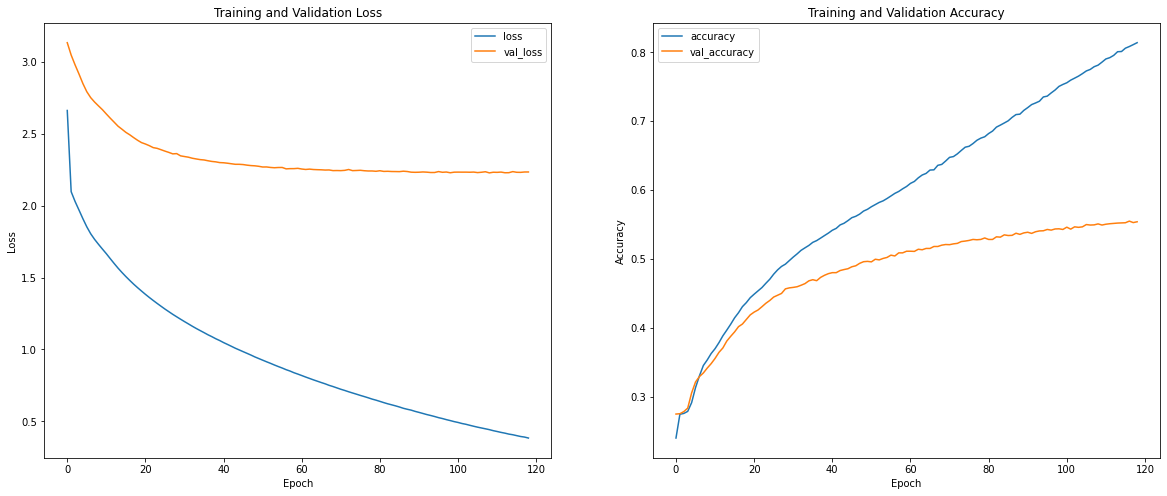

In [ ]:
# plot loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=ax[0])
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(ax=ax[1])
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

## Evaluate on a Test set

In [ ]:
# load the trained model
model.load_weights("/content/drive/MyDrive/english-nepali/checkpoints/model_checkpoint.h5")
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
loss, acc = model.evaluate(test_dataset, verbose=0)
print("{:25s}".format("Performance on Test Set"))
print("Loss: {}\nAccuracy: {:.2f}%".format(loss, acc*100))

Performance on Test Set  
Loss: 1.9797987937927246
Accuracy: 55.26%


In [ ]:
def prepare_data(sent):
    sent_tokens = english_tokenizer.texts_to_sequences([sent])
    ragged_tokens = tf.ragged.constant(sent_tokens)
    return ragged_tokens.to_tensor(shape=(None, english_maxlen))

In [ ]:
# write a function which returns the translated text in hindi
def translate(eng_sent, model):
    
    # prepare y_pred
    Y_pred = tf.fill(dims=(1, 1), value=2)
    # prepare encoder input
    X_encoder = prepare_data(eng_sent)
    
    index = 0
    next_ = 0
    # loop until max target length or until end token is predicted
    while index < nepali_maxlen and next_ != 2:
        # calculate the padding size
        padsize = nepali_maxlen - Y_pred.shape[1]
        # create input for decoder
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, padsize]])
        # get the probabilities of next prediction
        Y_proba = model.predict([X_encoder, X_decoder])[:, index:index+1]
        # get the next predicted token
        Y_proba_next = tf.argmax(Y_proba, axis=-1, output_type=tf.int32)
        # concatenate with Y_pred to predict next word
        Y_pred = tf.concat([Y_pred, Y_proba_next], axis=1)
        # assign current predicted token to next
        next_ = Y_proba_next.numpy()[0][0]
        # increment the index value
        index += 1
    # translate the sentences and return all except start and end tokens
    translated_sent = nepali_tokenizer.sequences_to_texts(Y_pred.numpy())
    return " ".join(translated_sent[0].split()[1:-1])

In [ ]:
# write a function to calculate similarity score between two sentence
def calculate_score(org, pred):
  set_r = set(org.split()).intersection(set(pred.split()))
  correct_cnt = len(set_r)
  return correct_cnt / len(org.split())


## Results

In [ ]:
# list of sentences to translate
english_test = list(X_test.values)
# original translation
nepali_test = list(y_test.values)

# initialize a list to store model translation
translations = []

# load model trained weights
model.load_weights("/content/drive/MyDrive/english-nepali/checkpoints/model_checkpoint.h5")

# loop over all english sentences
for sent in english_test:
  translation = translate(sent, model)
  translations.append(translation)

# create a dataframe
prediction_df = pd.DataFrame()
prediction_df['English'] = english_test
prediction_df['Nepali'] = nepali_test
prediction_df['Predicted'] = translations

# remove start and end tokens
prediction_df['English'] = prediction_df.English.str.strip('start_')
prediction_df['English'] = prediction_df.English.str.strip('end_')

prediction_df['Nepali'] = prediction_df.Nepali.str.strip('start_')
prediction_df['Nepali'] = prediction_df.Nepali.str.strip('end_')

# Calculate sentence similarity scores
scores = []
for row in prediction_df.itertuples():
  org = row.Nepali
  pred = row.Predicted
  score = calculate_score(org, pred)
  scores.append(score)

prediction_df['score'] = scores

# sort the dataframe from highest score to lowest
prediction_df = prediction_df.sort_values(by='score', ascending=False)
prediction_df.head()

,English,Nepali,Predicted,score
170,this is not mine,यो मेरो होइन,यो मेरो होइन,1.0
422,i am sick,म बिरामी छु,म बिरामी छु,1.0
906,my house is here,मेरो घर यहाँ छ,मेरो घर यहाँ छ,1.0
162,i work,म काम गर्छु,म काम गर्छु,1.0
80,i will watch it,म यसलाई हेर्नेछु,म यसलाई हेर्नेछु,1.0


In [ ]:
print("Total perfect predictions: {}/{}".format(len(prediction_df[prediction_df.score == 1.0]), len(X_test)))

Total perfect predictions: 17/989


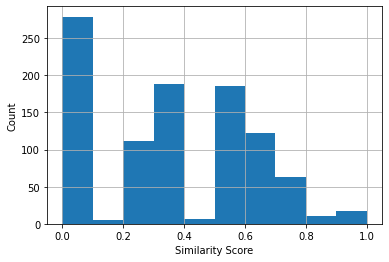

In [ ]:
# Plot the score distribution
prediction_df.score.hist()
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.show()

## Attention-Based Model

### Encoder

In [ ]:
embedding_dim = 300
units = 256
BATCH_SIZE = 64
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_valid.shape[0] // BATCH_SIZE

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units,
                batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size+1, embedding_dim)
        self.gru = GRU(self.enc_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer="glorot_uniform")
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))
    
encoder = Encoder(english_vocabsize, embedding_dim, units, BATCH_SIZE)

### Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units,
                 batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size+1, embedding_dim)
        self.gru = GRU(dec_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer="glorot_uniform")
        self.fc = keras.layers.Dense(vocab_size+1)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden,
                                                           enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights
    
decoder = Decoder(nepali_vocabsize, embedding_dim, units, BATCH_SIZE)


### Define Optimizer and the Loss Function

In [ ]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                         reduction='none')

def loss_function(y_true, y_pred):
    # mask = tf.math.logical_not(tf.math.equal(true, 0))
    loss_ = loss_object(y_true, y_pred)
    mask = tf.cast(y_true != 0, tf.float32)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
# Create checkpoints
checkpoint_dir = "/content/drive/MyDrive/english-nepali/checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training the Model

In [ ]:
# write a new function to create dataset for attention based model
def create_dataset_2(source, target, src_tokenizer=english_tokenizer, tar_tokenizer=nepali_tokenizer, batch_size=BATCH_SIZE):
    source_in = src_tokenizer.texts_to_sequences(source)
    target = tar_tokenizer.texts_to_sequences(target)
    
    # convert to ragged tensor
    source_in = tf.ragged.constant(source_in)
    target = tf.ragged.constant(target)
    
    # pad all data to max len
    source_in_padded = source_in.to_tensor(default_value=0)
    target_out_padded = target.to_tensor(default_value=0)
    
    # create a tensorflow datasest
    dataset = tf.data.Dataset.from_tensor_slices((source_in_padded, target_out_padded))
    # batch and prefetch dataset
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
# create a dataset comaptible with Attention Model
train_dataset_2 = create_dataset_2(X_train, y_train)
valid_dataset_2 = create_dataset_2(X_valid, y_valid)

In [ ]:
for row in train_dataset_2:
  print(english_tokenizer.sequences_to_texts([row[0][0, :].numpy()]))
  # print(nepali_tokenizer.sequences_to_texts([row[0][1][0, :].numpy()]))
  print(nepali_tokenizer.sequences_to_texts([row[1][0, :].numpy()]))
  break

['start_ i like puzzles end_']
['start_ मलाई पजलहरू मन पर्छ end_']


In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden, test=False):
    loss = 0
    val_loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([english_tokenizer.word_index['start_']]*BATCH_SIZE, 1)
        
        if test:
          # teacher forcing method
          for i in range(1, targ.shape[1]):
              predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
              val_loss += loss_function(targ[:, i], predictions)
              predicted_tokens = tf.argmax(predictions, axis=-1)
              dec_input = tf.expand_dims(predicted_tokens, 1)
              return val_loss / targ.shape[0]


        # teacher forcing method
        for i in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, i], predictions)
            dec_input = tf.expand_dims(targ[:, i], 1)
            
        batch_loss = (loss / int(targ.shape[0]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss


In [ ]:
# train for 60 epochs
EPOCHS = 60
training_loss, validation_loss = [], []
# initialize previous validation loss to a large value
# prev_val_loss = np.inf

# loop over number of epochs
for epoch in range(EPOCHS):
    start = time.time()
    # initialize encoder's hidden state
    enc_hidden = encoder.initialize_hidden_state()
    # initialize total training loss
    total_loss = 0
    # initialize total validation loss
    total_val_loss = 0

    # loop over all training batches
    for (batch, (inp, targ)) in enumerate(train_dataset_2.take(steps_per_epoch)):
        # calculate batch loss
        batch_loss = train_step(inp, targ, enc_hidden)
        # update total loss
        total_loss += batch_loss
        # print loss after every 100 batches
        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch+1,
                                                         batch,
                                                         batch_loss.numpy()))
    
    # loop over all validation batches
    for (batch, (inp, targ)) in enumerate(valid_dataset_2.take(val_steps_per_epoch)):
      val_loss = train_step(inp, targ, enc_hidden, test=True)
      total_val_loss += val_loss

    # save model every five epochs
    if (epoch+1 % 5 == 0):
      checkpoint.save(file_prefix=checkpoint_prefix)

    # calculate current validation loss
    # current_val_loss = total_val_loss / val_steps_per_epoch
    
    # save model if validation_loss improves
    # if current_val_loss < prev_val_loss:
    #   print("[INFO] Validation loss improved from {} to {}, saving model weights...".format(prev_val_loss, 
    #                                                                current_val_loss))
    #   checkpoint.save(file_prefix=checkpoint_prefix)
    #   # update previous validation loss
    #   prev_val_loss = current_val_loss
    
    # Display training status
    print("Epoch {} [Training Loss] : {:.4f}".format(epoch+1,
                                        total_loss / steps_per_epoch))
    print("Epoch {} [Validation Loss] : {:.4f}".format(epoch+1,
                                        total_val_loss / val_steps_per_epoch))
    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

    # store training loss
    training_loss.append(total_loss / steps_per_epoch)
    # store validation loss
    validation_loss.append(total_val_loss / val_steps_per_epoch)

Epoch 1 Batch 0 Loss 0.5585
Epoch 1 Batch 100 Loss 0.3195
Epoch 1 [Training Loss] : 0.3741
Epoch 1 [Validation Loss] : 0.0726
Time taken for 1 epoch 12.214845418930054 sec

Epoch 2 Batch 0 Loss 0.3268
Epoch 2 Batch 100 Loss 0.2953
Epoch 2 [Training Loss] : 0.3091
Epoch 2 [Validation Loss] : 0.0672
Time taken for 1 epoch 4.753885269165039 sec

Epoch 3 Batch 0 Loss 0.2967
Epoch 3 Batch 100 Loss 0.2735
Epoch 3 [Training Loss] : 0.2878
Epoch 3 [Validation Loss] : 0.0595
Time taken for 1 epoch 4.77759861946106 sec

Epoch 4 Batch 0 Loss 0.2740
Epoch 4 Batch 100 Loss 0.2582
Epoch 4 [Training Loss] : 0.2705
Epoch 4 [Validation Loss] : 0.0538
Time taken for 1 epoch 4.646082878112793 sec

Epoch 5 Batch 0 Loss 0.2547
Epoch 5 Batch 100 Loss 0.2446
Epoch 5 [Training Loss] : 0.2532
Epoch 5 [Validation Loss] : 0.0495
Time taken for 1 epoch 4.698887825012207 sec

Epoch 6 Batch 0 Loss 0.2382
Epoch 6 Batch 100 Loss 0.2300
Epoch 6 [Training Loss] : 0.2367
Epoch 6 [Validation Loss] : 0.0446
Time taken for

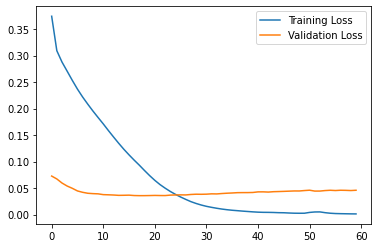

In [ ]:
# plot training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((nepali_maxlen, english_maxlen))
    inputs = [english_tokenizer.word_index[i] for i in sentence.split()]
    inputs = pad_sequences([inputs], maxlen=english_maxlen, padding="post")
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_output, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([nepali_tokenizer.word_index['start_']], 0)
    for i in range(nepali_maxlen):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden,
                                                              enc_output)
        predicted_id = tf.argmax(predictions[0]).numpy()
        if nepali_tokenizer.index_word[predicted_id] == 'end_':
            return result, sentence
        result += nepali_tokenizer.index_word[predicted_id] + ' '
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    # print("Input: {}".format(sentence))
    # print("Translated {}".format(result))
    return result

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Results

In [ ]:
# list of sentences to translate
english_test = list(X_test.values)
# original translation
nepali_test = list(y_test.values)

# initialize a list to store model translation
translations = []

# loop over all english sentences
for sent in english_test:
  translation = translate(sent)
  translations.append(translation)

# create a dataframe
prediction_df = pd.DataFrame()
prediction_df['English'] = english_test
prediction_df['Nepali'] = nepali_test
prediction_df['Predicted'] = translations

# remove start and end tokens
prediction_df['English'] = prediction_df.English.str.strip('start_')
prediction_df['English'] = prediction_df.English.str.strip('end_')

prediction_df['Nepali'] = prediction_df.Nepali.str.strip('start_')
prediction_df['Nepali'] = prediction_df.Nepali.str.strip('end_')

# Calculate sentence similarity scores
scores = []
for row in prediction_df.itertuples():
  org = row.Nepali
  pred = row.Predicted
  score = calculate_score(org, pred)
  scores.append(score)

# add scores to dataframe
prediction_df['score'] = scores

# sort the dataframe with best highest to lowest score
prediction_df = prediction_df.sort_values(by='score', ascending=False)

# reset index
prediction_df.reset_index(drop=True, inplace=True)

# Display the top predictions
prediction_df.head()


,English,Nepali,Predicted,score
0,it is my book,यो मेरो किताब हो,यो मेरो किताब हो,1.0
1,it was delicious,यो स्वादिष्ट थियो,यो स्वादिष्ट थियो,1.0
2,look at that,त्यो हेर,त्यो हेर,1.0
3,i work,म काम गर्छु,म काम गर्छु,1.0
4,i can see tom,म टम देख्न सक्छु,म टम देख्न सक्छु,1.0


In [ ]:
# Worst predictions
prediction_df.tail()

,English,Nepali,Predicted,score
984,cut it in half,आधा मा काट्नुहोस्,यसलाई फ्रान्सेलीमा भन्नुहोस्,0.0
985,who remembers,कसले याद गर्छ,को भन,0.0
986,i got sunburned,म सनबर्न भयो,मैले कार्ड दिए,0.0
987,keep dancing,नाउने राख्नुहोस्,मरियमले गणना गर,0.0
988,i make the rules,म नियमहरू बनाउँछु,मैले खाजा लात,0.0


In [ ]:
print("Total perfect predictions: {}/{}".format(len(prediction_df[prediction_df.score == 1.0]), len(X_test)))

Total perfect predictions: 134/989


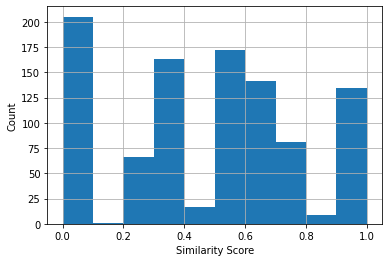

In [ ]:
# Plot the score distribution
prediction_df.score.hist()
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.show()

In [ ]:
prediction_df.to_csv('/content/drive/MyDrive/english-nepali/data/pred-eng-nep-attn.csv', index=False)

In [ ]:
i = 0
while True:
  clear_output(wait=True)
  print(prediction_df.iloc[i:i+10, [1, 2]])
  print("\nEnter m for more")
  more = input()
  if more == 'm':
    i += 10
  else:
    break

                       Nepali                Predicted
551       तिनीहरू यहाँ छैनन्       तिनीहरू यहाँ छैनन् 
531              टम यहाँ छैन              टम यहाँ छैन 
512      तिनीहरू मेरो होइनन्      तिनीहरू मेरो होइनन् 
501            यो तपाईंको हो      यो तपाईंको गल्ती हो 
440              टम तयार छैन              टम तयार छैन 
433   उसले उसलाई मद्दत गर्दछ   उसले उसलाई मद्दत गर्दछ 
422              म बिरामी छु              म बिरामी छु 
186            टम यो मन पर्छ            टम यो मन पर्छ 
36        मलाई कुकुर मन पर्छ       मलाई कुकुर मन पर्छ 
201         यो धेरै राम्रो छ         यो धेरै राम्रो छ 

Enter m for more

